In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

class FourierFeatureEmbedding(nn.Module):
    def __init__(self, in_features: int, m: int, sigma: float, keep_dims: None | list[int] = None):
        super().__init__()

        self.in_features = in_features
        self.m = m
        self.sigma = sigma
        self.keep_dims = None if keep_dims is None else keep_dims[:]
        
        if keep_dims is None:
            embed_dims = list(range(in_features))
        else:
            embed_dims = [i for i in range(in_features) if i not in keep_dims]
            if len(embed_dims) == 0:
                raise ValueError("'keep_dims' list must not cover all the input features!")
        self.embed_dims = embed_dims

        self.register_buffer("B", torch.randn(len(embed_dims), m) * sigma)

        self.out_features = 2*m
        if  isinstance(self.keep_dims, list):
            self.out_features += len(self.keep_dims)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_embed = x[:, self.embed_dims]
        xB = torch.matmul(x_embed, self.B)
        result = torch.cat( (torch.cos(xB), torch.sin(xB)), dim=1 )
        
        if self.keep_dims is None:
            return result
        else:
            return torch.cat((result, x[:, self.keep_dims]), dim=1)

One-dimentional test:

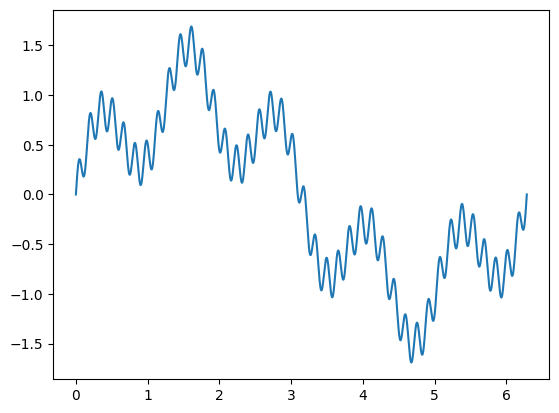

In [73]:
u_exact = lambda x: torch.sin(x) + 0.5*torch.sin(5*x) + 0.2*torch.sin(40*x)

domain = [0, 2*torch.pi]
x = torch.linspace(*domain, 10000)
plt.plot(x, u_exact(x))
plt.show()

In [69]:
# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
n = 500
m = 32
sigma = 10
n_epochs = 5000

device = 'cuda'
torch.manual_seed(2008)
model = nn.Sequential(
    nn.Linear(1, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)
ffe_layer = FourierFeatureEmbedding(1, m=m, sigma=sigma)
model_ffe = nn.Sequential(
    ffe_layer,
    nn.Linear(ffe_layer.out_features, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_ffe=torch.optim.Adam(model_ffe.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)
loss_ffe = torch.zeros(n_epochs)
for k in range(1, n_epochs + 1):
    x = (domain[1] - domain[0]) * torch.rand(n, 1, device=device) + domain[0]

    u = model(x)
    optimizer.zero_grad()
    tmp = torch.mean( (u - u_exact(x))**2 )
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()

    u_ffe = model_ffe(x)
    optimizer_ffe.zero_grad()
    tmp_ffe = torch.mean( (u_ffe - u_exact(x))**2 )
    tmp_ffe.backward()
    optimizer_ffe.step()
    loss_ffe[k-1] = tmp_ffe.detach().cpu()

    if k == 1 or k % 100 == 0:
        print(f"epoch = {k:6d}, loss = {loss[k-1]:10.4e}, loss_ffe = {loss_ffe[k-1]:10.4e}")

epoch =      1, loss = 6.6693e-01, loss_ffe = 6.5853e-01
epoch =    100, loss = 1.9345e-01, loss_ffe = 1.4540e-02
epoch =    200, loss = 1.5205e-01, loss_ffe = 3.4082e-03
epoch =    300, loss = 1.3397e-01, loss_ffe = 1.1511e-04
epoch =    400, loss = 1.3501e-01, loss_ffe = 5.4186e-05
epoch =    500, loss = 1.1759e-01, loss_ffe = 3.9311e-05
epoch =    600, loss = 1.1433e-01, loss_ffe = 3.1543e-05
epoch =    700, loss = 1.1802e-01, loss_ffe = 2.6182e-05
epoch =    800, loss = 1.1014e-01, loss_ffe = 2.2261e-05
epoch =    900, loss = 9.8295e-02, loss_ffe = 1.9769e-05
epoch =   1000, loss = 9.8235e-02, loss_ffe = 1.6231e-05
epoch =   1100, loss = 9.1199e-02, loss_ffe = 1.1309e-05
epoch =   1200, loss = 8.0441e-02, loss_ffe = 1.1886e-05
epoch =   1300, loss = 8.5600e-02, loss_ffe = 2.1139e-05
epoch =   1400, loss = 8.5232e-02, loss_ffe = 1.8455e-05
epoch =   1500, loss = 7.5754e-02, loss_ffe = 1.1264e-05
epoch =   1600, loss = 7.0897e-02, loss_ffe = 1.3448e-05
epoch =   1700, loss = 7.2261e-

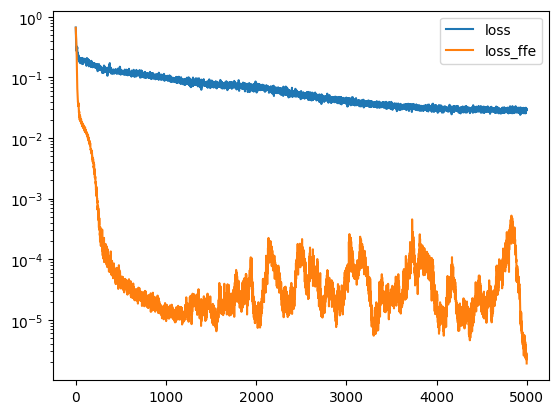

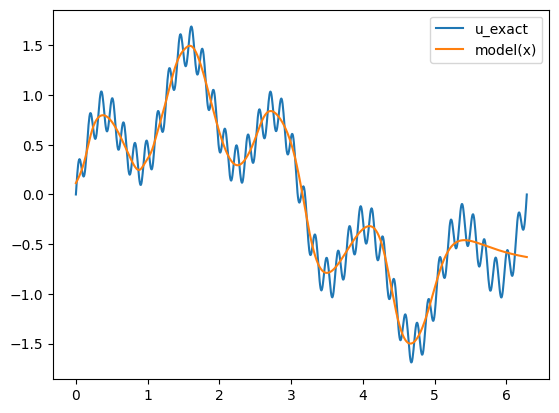

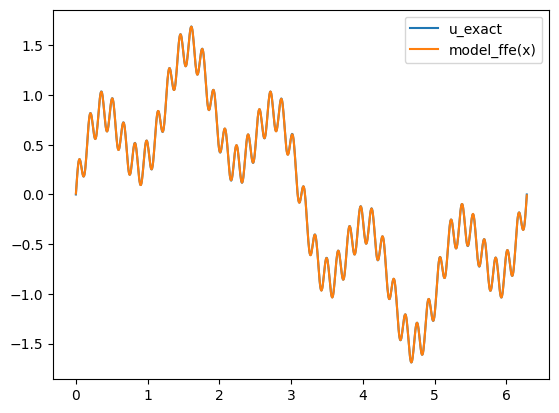

In [70]:
plt.semilogy(loss.detach().cpu(), label="loss")
plt.semilogy(loss_ffe.detach().cpu(), label="loss_ffe")
plt.legend()
plt.show()

model = model.to("cpu")
model_ffe = model_ffe.to("cpu")
x = torch.linspace(*domain, 1000).reshape(-1, 1)

plt.plot(x, u_exact(x), label="u_exact")
plt.plot(x, model(x).detach().cpu(), label="model(x)")
plt.legend()
plt.show()

plt.plot(x, u_exact(x), label="u_exact")
plt.plot(x, model_ffe(x).detach().cpu(), label="model_ffe(x)")
plt.legend()
plt.show()

Two-dimentional test:

Text(0, 0.5, 'y')

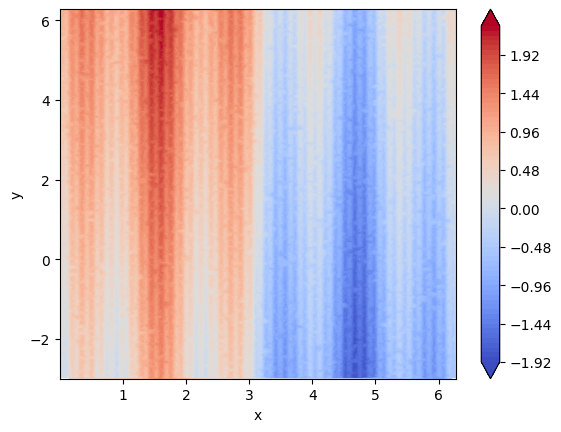

In [82]:
def sample_points_2D(bounds: list[float], n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
    x_min, y_min, x_max, y_max = bounds
    
    xy = torch.rand(n, 2, device=device)
    xy[:, 0] = xy[:, 0] * (x_max - x_min) + x_min
    xy[:, 1] = xy[:, 1] * (y_max - y_min) + y_min 
    return xy

u_exact = lambda xy: torch.sin(xy[:, 0:1]) + 0.5*torch.sin(5*xy[:, 0:1]) + \
    0.2*torch.sin(40*xy[:, 0:1]) + 0.1*xy[:, 1:2]

domain = [0, -3, 2*torch.pi, 2*torch.pi]    # x_min, y_min, x_max, y_max
xy = sample_points_2D(bounds=domain, n=30000)

fig, ax = plt.subplots()
triang = tri.Triangulation(xy[:, 0], xy[:, 1])
tcf = plt.tricontourf(triang, u_exact(xy).squeeze(), levels=80, extend='both', cmap='coolwarm')
fig.colorbar(tcf)
plt.xlabel("x")
plt.ylabel("y")


In [95]:
# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
n = 15000
m = 32
sigma = 10
n_epochs = 1000

device = 'cuda'
torch.manual_seed(2008)
model = nn.Sequential(
    nn.Linear(2, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)
ffe_layer = FourierFeatureEmbedding(2, m=m, sigma=sigma)
model_ffe = nn.Sequential(
    ffe_layer,
    nn.Linear(ffe_layer.out_features, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)
ffe_partial_layer = FourierFeatureEmbedding(2, m=m, sigma=sigma, keep_dims=[1])    # Применяет FFE только для оси x
model_ffe_partial = nn.Sequential(
    ffe_partial_layer,
    nn.Linear(ffe_partial_layer.out_features, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_ffe=torch.optim.Adam(model_ffe.parameters(), lr=1e-3)
optimizer_ffe_partial=torch.optim.Adam(model_ffe_partial.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)
loss_ffe = torch.zeros(n_epochs)
loss_ffe_partial = torch.zeros(n_epochs)
for k in range(1, n_epochs + 1):
    xy = sample_points_2D(bounds=domain, n=n, device=device)

    u = model(xy)
    optimizer.zero_grad()
    tmp = torch.mean( (u - u_exact(xy))**2 )
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()

    u_ffe = model_ffe(xy)
    optimizer_ffe.zero_grad()
    tmp_ffe = torch.mean( (u_ffe - u_exact(xy))**2 )
    tmp_ffe.backward()
    optimizer_ffe.step()
    loss_ffe[k-1] = tmp_ffe.detach().cpu()

    u_ffe_partial = model_ffe_partial(xy)
    optimizer_ffe_partial.zero_grad()
    tmp_ffe_partial = torch.mean( (u_ffe_partial - u_exact(xy))**2 )
    tmp_ffe_partial.backward()
    optimizer_ffe_partial.step()
    loss_ffe_partial[k-1] = tmp_ffe_partial.detach().cpu()

    if k == 1 or k % 100 == 0:
        print(f"epoch = {k:6d}, loss = {loss[k-1]:10.4e}, loss_ffe = {loss_ffe[k-1]:10.4e}, loss_ffe_partial = {loss_ffe_partial[k-1]:10.4e}")

epoch =      1, loss = 6.8961e-01, loss_ffe = 7.7934e-01, loss_ffe_partial = 7.9883e-01
epoch =    100, loss = 2.0421e-01, loss_ffe = 4.1094e-01, loss_ffe_partial = 7.7417e-03
epoch =    200, loss = 1.7259e-01, loss_ffe = 9.4140e-02, loss_ffe_partial = 3.8769e-04
epoch =    300, loss = 1.4791e-01, loss_ffe = 5.3351e-02, loss_ffe_partial = 1.8478e-04
epoch =    400, loss = 1.3172e-01, loss_ffe = 3.7903e-02, loss_ffe_partial = 1.1164e-04
epoch =    500, loss = 1.2383e-01, loss_ffe = 3.0829e-02, loss_ffe_partial = 8.3466e-05
epoch =    600, loss = 1.1561e-01, loss_ffe = 2.6854e-02, loss_ffe_partial = 6.2588e-05
epoch =    700, loss = 1.1000e-01, loss_ffe = 2.4997e-02, loss_ffe_partial = 4.9182e-05
epoch =    800, loss = 1.0177e-01, loss_ffe = 2.3242e-02, loss_ffe_partial = 3.8937e-05
epoch =    900, loss = 9.3537e-02, loss_ffe = 2.2083e-02, loss_ffe_partial = 3.1466e-05
epoch =   1000, loss = 8.8658e-02, loss_ffe = 2.0787e-02, loss_ffe_partial = 2.8638e-05


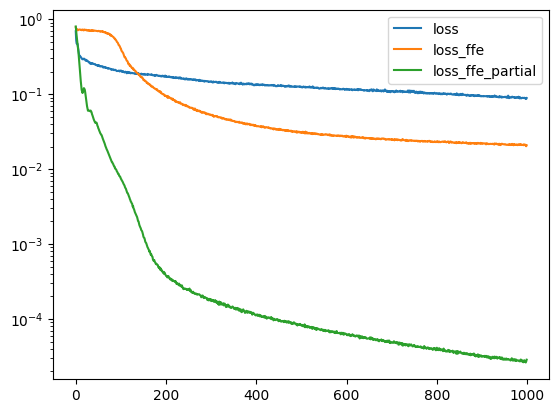

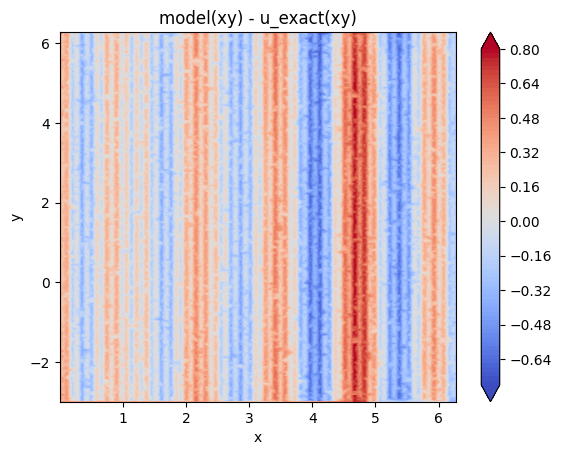

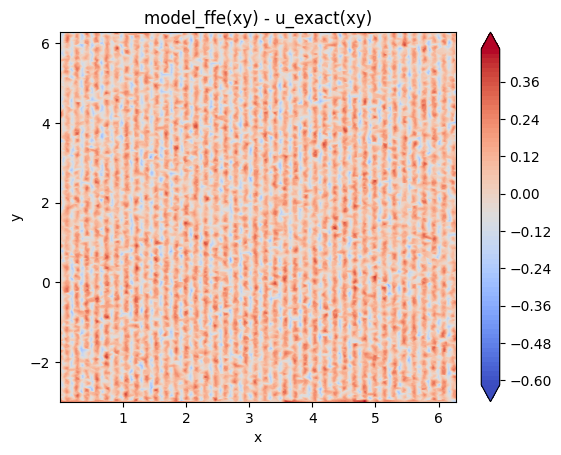

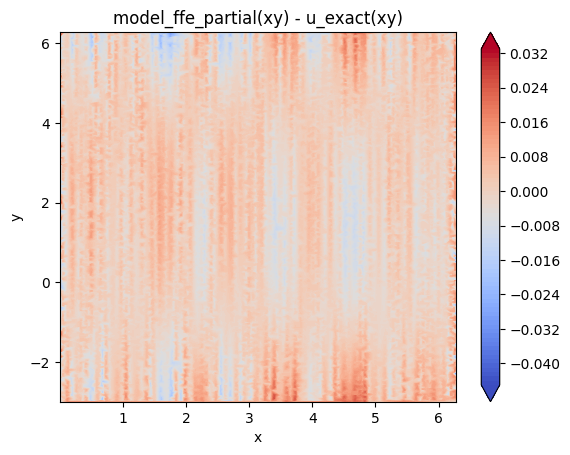

In [96]:
with torch.no_grad():
    plt.semilogy(loss.detach().cpu(), label="loss")
    plt.semilogy(loss_ffe.detach().cpu(), label="loss_ffe")
    plt.semilogy(loss_ffe_partial.detach().cpu(), label="loss_ffe_partial")
    plt.legend()
    plt.show()

    model = model.to("cpu")
    model_ffe = model_ffe.to("cpu")
    model_ffe_partial = model_ffe_partial.to("cpu")
    xy = sample_points_2D(bounds=domain, n=30000)

    # model - u_exact
    fig, ax = plt.subplots()
    triang = tri.Triangulation(xy[:, 0], xy[:, 1])
    tcf = plt.tricontourf(triang, (model(xy) - u_exact(xy)).squeeze(), 
                        levels=80, extend='both', cmap='coolwarm')
    fig.colorbar(tcf)
    plt.title("model(xy) - u_exact(xy)")
    plt.xlabel("x")
    plt.ylabel("y")

    # model_ffe - u_exact
    fig, ax = plt.subplots()
    triang = tri.Triangulation(xy[:, 0], xy[:, 1])
    tcf = plt.tricontourf(triang, (model_ffe(xy) - u_exact(xy)).squeeze(), 
                        levels=80, extend='both', cmap='coolwarm')
    fig.colorbar(tcf)
    plt.title("model_ffe(xy) - u_exact(xy)")
    plt.xlabel("x")
    plt.ylabel("y")

    # model_ffe_partial - u_exact
    fig, ax = plt.subplots()
    triang = tri.Triangulation(xy[:, 0], xy[:, 1])
    tcf = plt.tricontourf(triang, (model_ffe_partial(xy) - u_exact(xy)).squeeze(), 
                        levels=80, extend='both', cmap='coolwarm')
    fig.colorbar(tcf)
    plt.title("model_ffe_partial(xy) - u_exact(xy)")
    plt.xlabel("x")
    plt.ylabel("y")